# Using ML models Predicting Volatility
- Afet Ibadova 453818
- Daryush Ray 455894

## Introduction
**The aim of the Project** - (this part need to be added)

## 1. Data Collection

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

ticker_symbol = "^GSPC"
#<---- 20 year data
start_date = "2002-01-01"
end_date = "2022-01-01"

df = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [83]:
print(df.head(4))
print(df.describe())
print(df.info())


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2002-01-02  1148.079956  1154.670044  1136.229980  1154.670044  1154.670044   
2002-01-03  1154.670044  1165.270020  1154.010010  1165.270020  1165.270020   
2002-01-04  1165.270020  1176.550049  1163.420044  1172.510010  1172.510010   
2002-01-07  1172.510010  1176.969971  1163.550049  1164.890015  1164.890015   

                Volume  
Date                    
2002-01-02  1171000000  
2002-01-03  1398900000  
2002-01-04  1513000000  
2002-01-07  1308300000  
              Open         High          Low        Close    Adj Close  \
count  5036.000000  5036.000000  5036.000000  5036.000000  5036.000000   
mean   1818.352420  1828.414738  1807.616154  1818.718496  1818.718496   
std     885.166613   888.433666   881.817104   885.479906   885.479906   
min     679.280029   695.270020   666.789978   676.530029   676.530029   
25%  

## 2. EDA

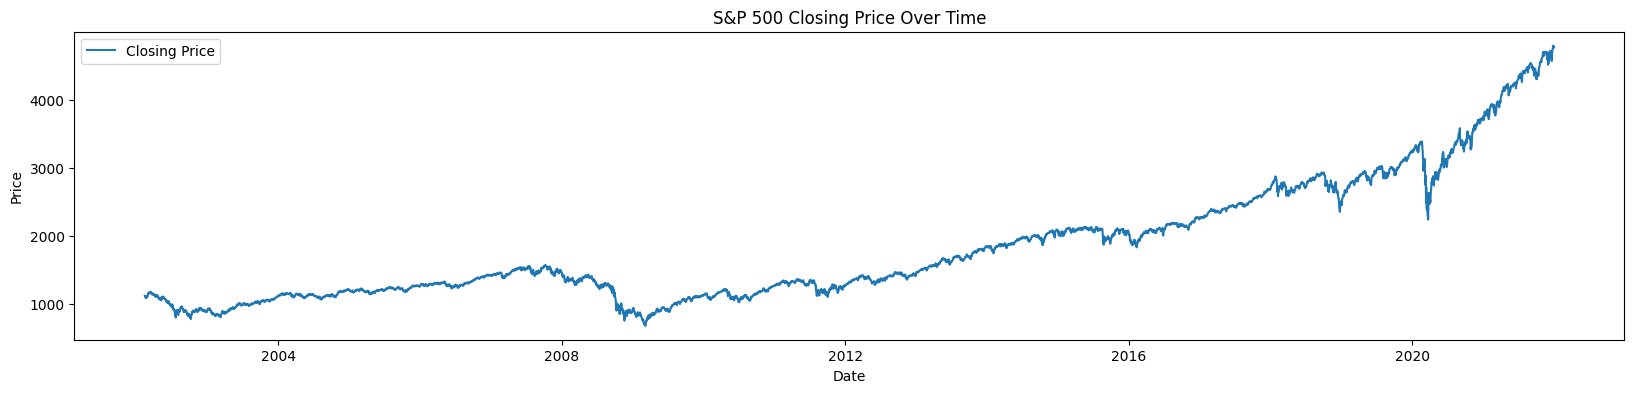

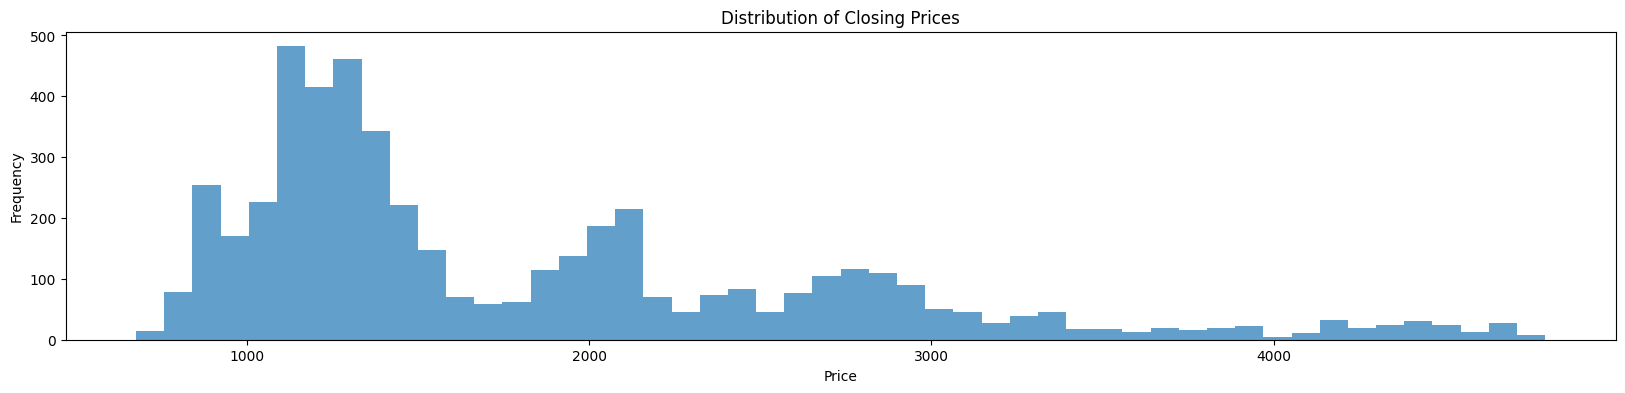

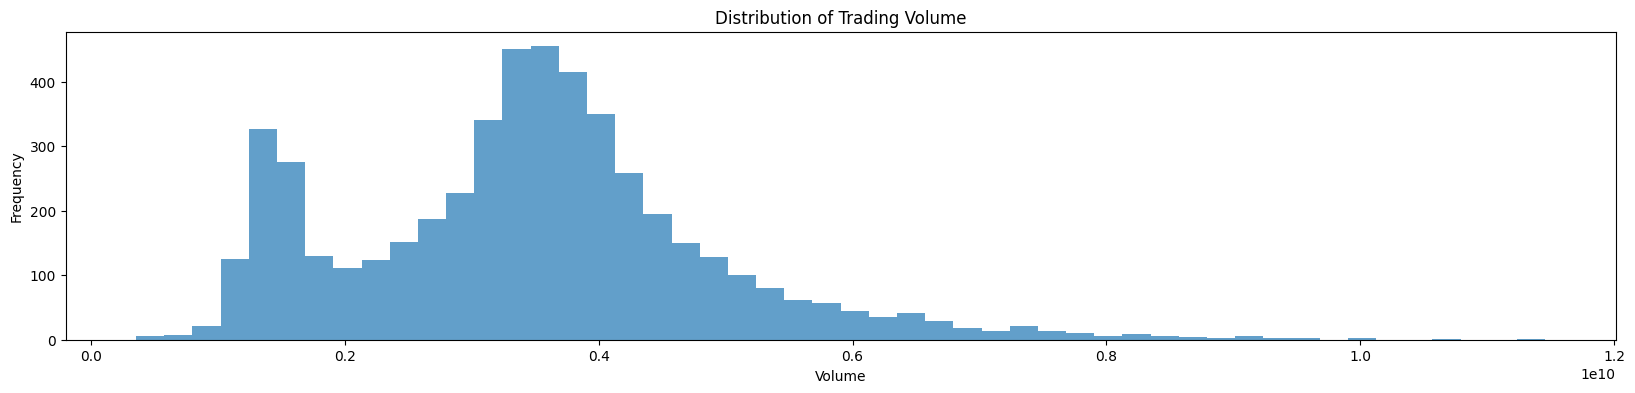

In [99]:
#<--- closing prices
plt.figure(figsize=(20, 4))
plt.plot(df['Close'], label='Closing Price')
plt.title('S&P 500 Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#<--- distribution of closing
plt.figure(figsize=(20, 4))
plt.hist(df['Close'], bins=50, alpha=0.7)
plt.title('Distribution of Closing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#<--- volume
plt.figure(figsize=(20, 4))
plt.hist(df['Volume'], bins=50, alpha=0.7)
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

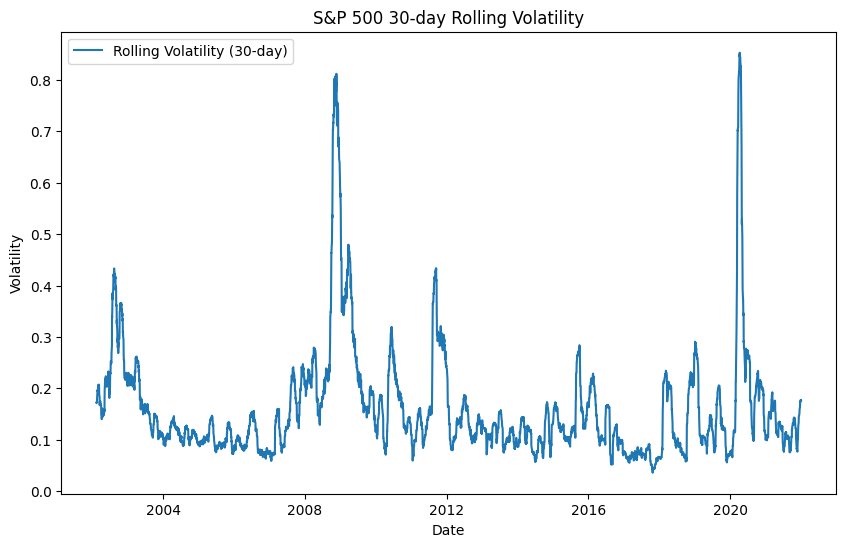

In [85]:
#<--- daily returns
df['Daily_Return'] = df['Close'].pct_change()

# Calculate rolling volatility (30-day window)
df['Volatility'] = df['Daily_Return'].rolling(window=30).std() * np.sqrt(252)  # Annualized

# Plot the volatility
plt.figure(figsize=(10, 6))
plt.plot(df['Volatility'], label='Rolling Volatility (30-day)')
plt.title('S&P 500 30-day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

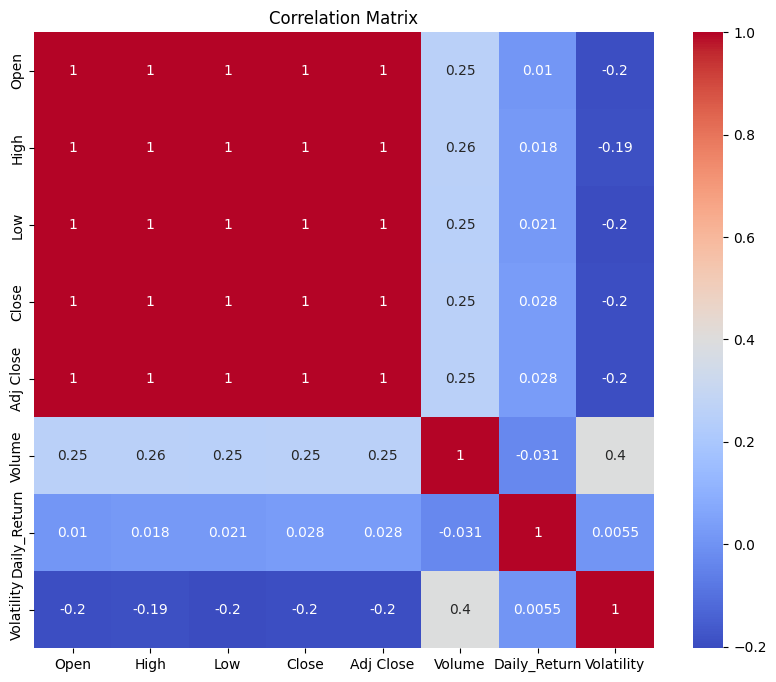

In [86]:
#<--- correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 3. Data Preprocessing and Feature Engineering

In [87]:
df.isnull().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Daily_Return     1
Volatility      30
dtype: int64

In [88]:
df['Daily_Return'].fillna(0, inplace=True) #<--- first day's return we assume 0
df.dropna(inplace=True) #<--- dropping the Volatility windows since it is realitvely small
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily_Return    0
Volatility      0
dtype: int64

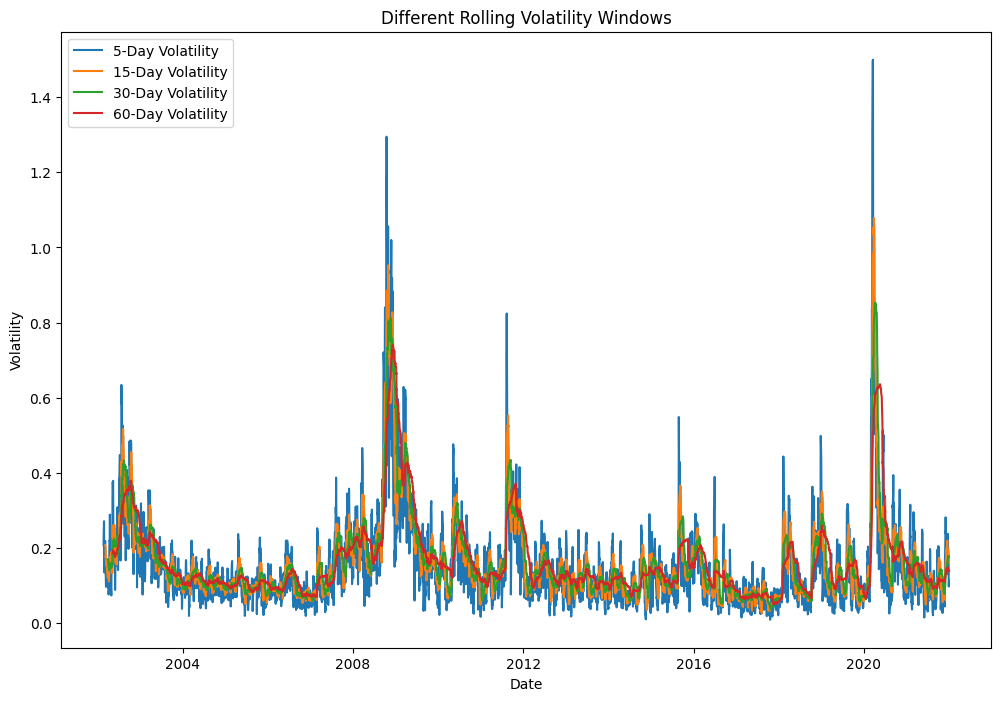

In [89]:
#<--- rolling volatility with different windows

for window in [5, 15, 30, 60]:
    df[f'Volatility_{window}d'] = df['Daily_Return'].rolling(window=window).std() * np.sqrt(252)  # Annualized

##<---- Different window sizes could capture volatility over different time horizons. 15-day window might capture short-term volatility, while a 90-day window might reflect longer-term trends.
plt.figure(figsize=(12, 8))
plt.plot(df['Volatility_5d'], label='5-Day Volatility')
plt.plot(df['Volatility_15d'], label='15-Day Volatility')
plt.plot(df['Volatility_30d'], label='30-Day Volatility')
plt.plot(df['Volatility_60d'], label='60-Day Volatility')
plt.title('Different Rolling Volatility Windows')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

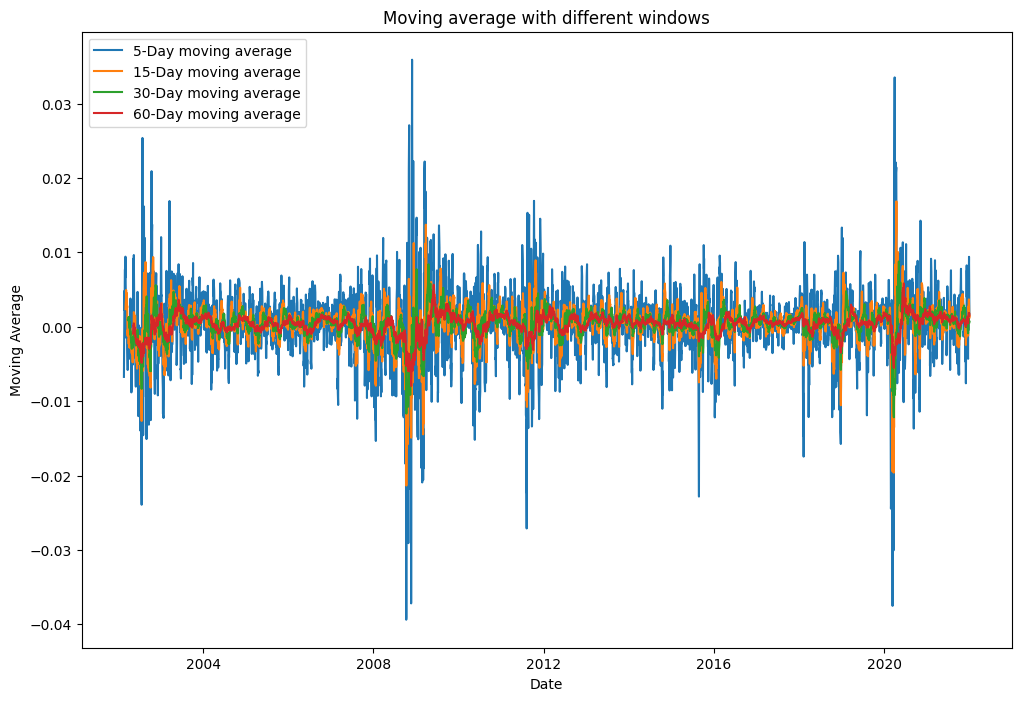

In [97]:
#<--- moving average with different corresponding volatility windows
for window in [5, 15, 30, 60]:
    df[f'MA_{window}d'] = df['Daily_Return'].rolling(window=window).mean()

##<---- Different window sizes could capture volatility over different time horizons. 15-day window might capture short-term volatility, while a 90-day window might reflect longer-term trends.
plt.figure(figsize=(12, 8))
plt.plot(df['MA_5d'], label='5-Day moving average')
plt.plot(df['MA_15d'], label='15-Day moving average')
plt.plot(df['MA_30d'], label='30-Day moving average')
plt.plot(df['MA_60d'], label='60-Day moving average')
plt.title('Moving average with different windows')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.legend()
plt.show()

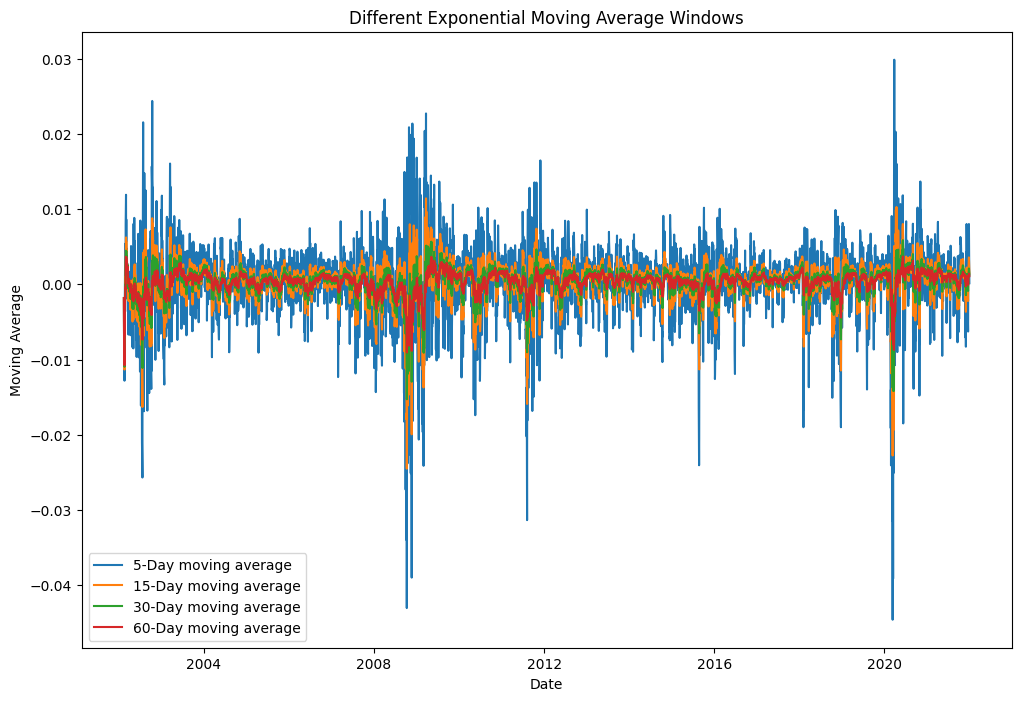

In [98]:
#<--- exponential moving average with different corresponding volatility windows

for window in [5, 15, 30, 60]:
    df[f'EMA_{window}d'] = df['Daily_Return'].ewm(span=window).mean()

plt.figure(figsize=(12, 8))
plt.plot(df['EMA_5d'], label='5-Day moving average')
plt.plot(df['EMA_15d'], label='15-Day moving average')
plt.plot(df['EMA_30d'], label='30-Day moving average')
plt.plot(df['EMA_60d'], label='60-Day moving average')
plt.title('Different Exponential Moving Average Windows')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.legend()
plt.show()

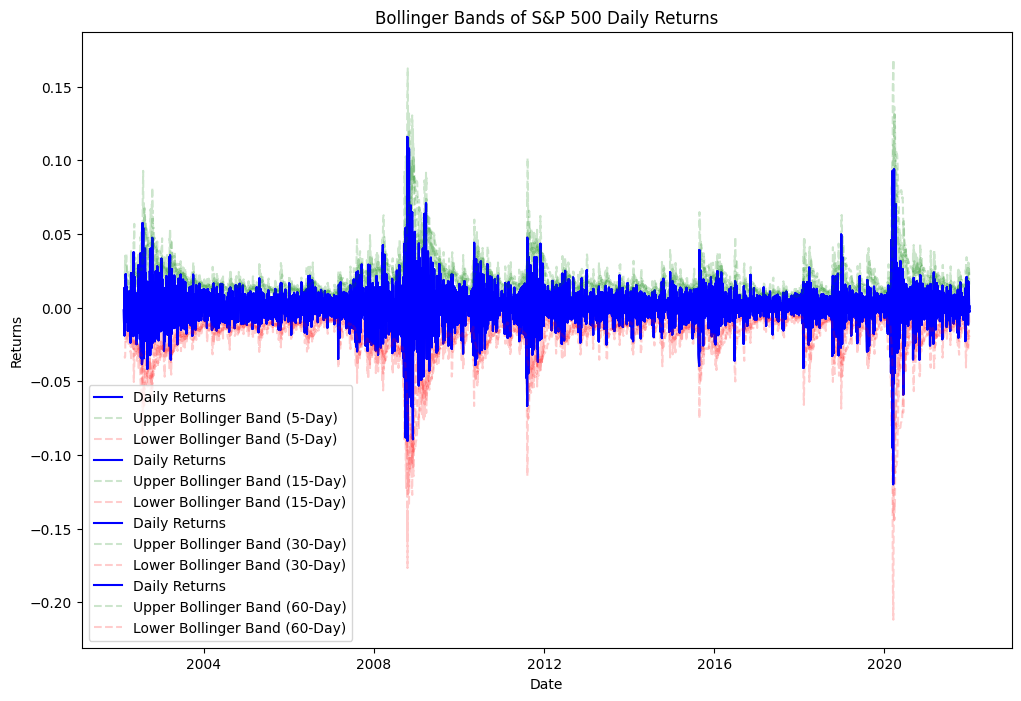

In [110]:
#<--- defining the initial parameters for the Bollinger Bands
Daily_Return_windows = [5, 15, 30, 60]
std_dev_multiplier = 2

#<--- calculating the Bollinger Bands
for window in Daily_Return_windows:
    df[f'RollingMean_{window}d'] = df['Daily_Return'].rolling(window=window).mean()
    df[f'RollingStd_{window}d'] = df['Daily_Return'].rolling(window=window).std()
    df[f'UpperBollinger_{window}d'] = df[f'RollingMean_{window}d'] + (df[f'RollingStd_{window}d'] * std_dev_multiplier)
    df[f'LowerBollinger_{window}d'] = df[f'RollingMean_{window}d'] - (df[f'RollingStd_{window}d'] * std_dev_multiplier)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for window in Daily_Return_windows:
    plt.plot(df['Daily_Return'], label='Daily Returns', alpha=1, color='blue')
    plt.plot(df[f'UpperBollinger_{window}d'], label=f'Upper Bollinger Band ({window}-Day)', linestyle='--', alpha=0.2, color='green')
    plt.plot(df[f'LowerBollinger_{window}d'], label=f'Lower Bollinger Band ({window}-Day)', linestyle='--', alpha=0.2, color='red')

plt.title('Bollinger Bands of S&P 500 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

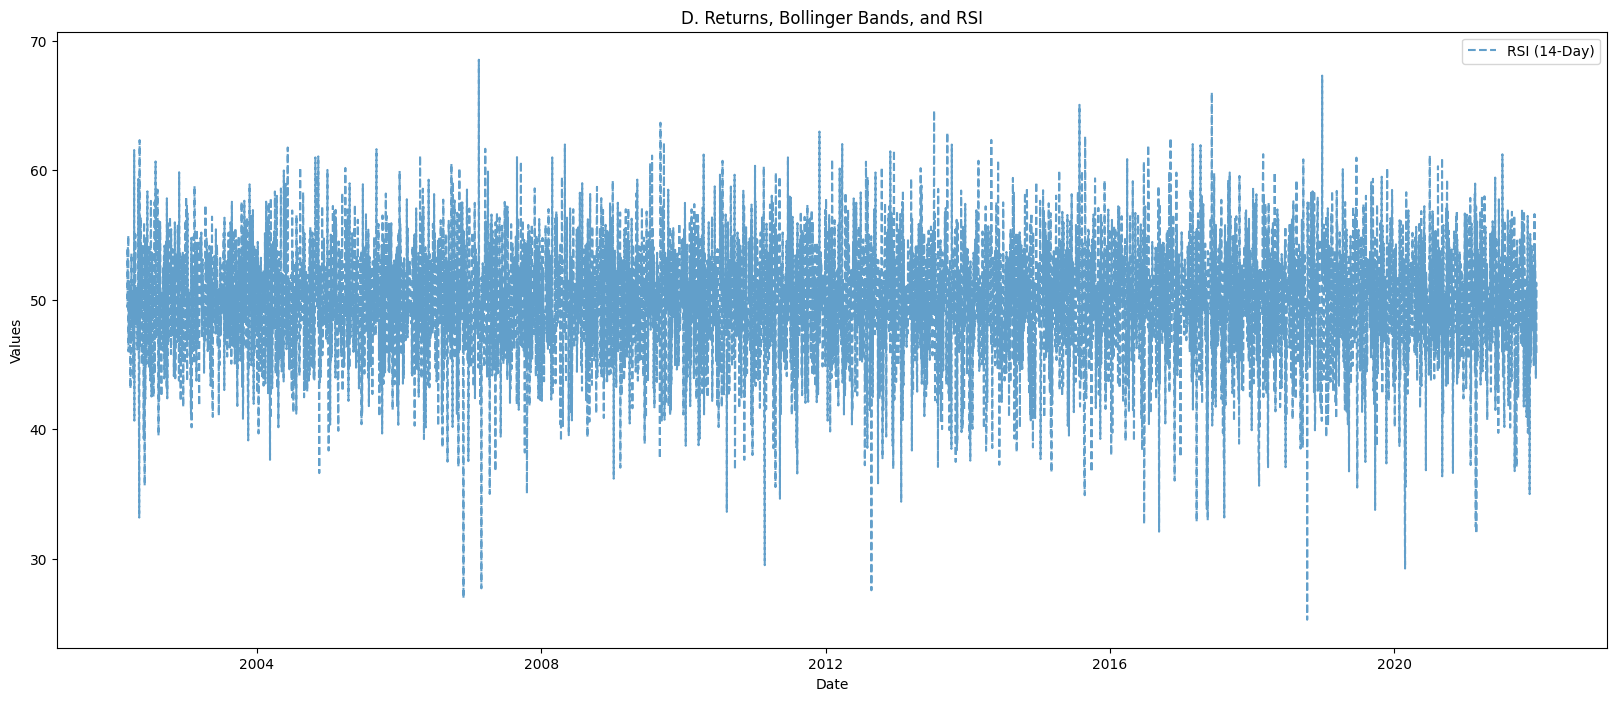

In [111]:
#<--- main function to calculate the RSI
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

rsi_window = 14  #<--- most common window size
df['RSI'] = calculate_rsi(df['Daily_Return'], window=rsi_window)

plt.figure(figsize=(20, 8))
plt.plot(df['RSI'], label=f'RSI ({rsi_window}-Day)', linestyle='--', alpha=0.7)

plt.title('D. Returns, Bollinger Bands, and RSI')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [94]:
df['Lagged_Close'] = df['Close'].shift(1) #<--- shift by 1 day
